In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab3.ipynb")

![](img/571_lab_banner.png)

# Lab 3: Text classification and hyperparameter optimization

<br><br>

## Imports

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

%matplotlib inline

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert-warning">
    
## Instructions  
rubric={mechanics}

You will earn points for following these instructions and successfully submitting your work on Gradescope.  

### Before you start  

- Read the **[Use of Generative AI Policy](https://ubc-mds.github.io/policies/)**.
  
- Review the **[General Lab Instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/)**.
    
- Check the **[MDS Rubrics](https://github.com/UBC-MDS/public/tree/master/rubric)** for grading criteria.

### Before submitting  

- **Run all cells** (▶▶ button) to ensure the notebook executes cleanly from top to bottom.

  - Execution counts must start at **1** and be sequential.
    
  - Notebooks with missing outputs or errors may lose marks.
    
- **Include a clickable link to your GitHub repository** below this cell.

- Make at least 3 commits to your GitHub repository and ensure it's up to date. If Gradescope becomes inaccessible, we'll grade the most recent GitHub version submitted before the deadline.

- **Do not upload or push data files** used in this lab to GitHub or Gradescope. (A `.gitignore` is provided to prevent this.)  



### Submitting on Gradescope  

- Upload **only** your `.ipynb` file (with outputs shown) and any required output files. Do **not** submit extra files.
  
- If needed, refer to the [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/).  
- If your notebook is too large to render, also upload a **Web PDF** or **HTML** version.  
  - You can create one using **File $\rightarrow$ Save and Export Notebook As**.  
  - If you get an error when creating a PDF, try running the following commands in your lab directory:  

    ```bash
    conda install -c conda-forge nbconvert-playwright
    jupyter nbconvert --to webpdf lab1.ipynb
    ```  

  - Ensure all outputs are visible in your PDF or HTML file; TAs cannot grade your work if outputs are missing.

</div>


_Points:_ 4

YOUR REPO LINK GOES HERE

<!-- END QUESTION -->

<br><br>

## Introduction <a name="in"></a>
<hr>

In this lab, we'll focus on two things:
1. Working with text data
2. Hyperparameter optimization

As this is a quiz week, this lab would be shorter than previous weeks' labs.

## Exercise 1: Introducing the dataset and EDA <a name="1"></a>
<hr>

Let's develop our own SMS spam classification system using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The goal is to predict whether a specific text message is spam or not. 

Please download the CSV and save it as `spam.csv` locally under the `data` folder. 

> **Some text messages in this dataset may contain offensive language, a reflection of the realities on such platforms 😔. If you are sensitive to such content, please avoid reading the raw messages.** 


The starter code provided below assumes that the data file is saved as "spam.csv" and is located in the data directory of this lab folder.

In [3]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data splitting

As usual, let's start by splitting the data. This time, we'll keep both `X` and `y` in the training and test splits since we'll need them for our exploratory data analysis (EDA).

In [4]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends ...
1283,ham,Yes i thought so. Thanks.
2327,spam,URGENT! Your mobile number *************** WON...
1103,ham,Aiyah sorry lor... I watch tv watch until i fo...


### Simple EDA

Just as we examine distributions and summary statistics of features in tabular data during EDA, we can also perform exploratory analysis on text data. However, traditional EDA techniques don't directly apply to text. Here, we'll explore one simple hypothesis that the length of a message (for example, “OK” has a length of 2) may differ between spam and ham (non-spam) messages. Message length might even serve as a useful feature for classifying messages as spam or ham. Let's investigate this idea.

In [5]:
# Add a length column

train_df["length"] = train_df["sms"].str.len()

In [6]:
# Compute summary stats by class

summary = (
    train_df.groupby("target")["length"]
    .agg(["mean", "min", "max"])
    .rename(columns={"mean": "avg_len", "min": "shortest_len", "max": "longest_len"})
)

summary

,avg_len,shortest_len,longest_len
target,,,
ham,70.957845,2,790
spam,138.657980,13,224


Let's look at the shortest and longest spam and non-spam (ham) messages.

In [7]:
for label in ["spam", "ham"]:
    subset = train_df[train_df["target"] == label]
    shortest_msg = subset.loc[subset["length"].idxmin(), "sms"]
    longest_msg = subset.loc[subset["length"].idxmax(), "sms"]
    print(f"\n {label.upper()} MESSAGES")
    print(f"Shortest ({summary.loc[label, 'shortest_len']} chars): {shortest_msg}")
    print(f"Longest  ({summary.loc[label, 'longest_len']} chars): {longest_msg}")


 SPAM MESSAGES
Shortest (13 chars): 2/2 146tf150p
Longest  (224 chars): Hi, this is Mandy Sullivan calling from HOTMIX FM...you are chosen to receive å£5000.00 in our Easter Prize draw.....Please telephone 09041940223 to claim before 29/03/05 or your prize will be transferred to someone else....

 HAM MESSAGES
Shortest (2 chars): Ok
Longest  (790 chars): The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarasse

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 1.1 Discussion
rubric={reasoning}

**Your tasks:**

1. Describe any differences you observe in the average lengths of spam and ham messages. What might these differences suggest?  
2. Suppose we want to train a supervised machine learning model using this data.  
   - How would you encode the `sms` column?  
   - Would one-hot encoding be appropriate for this type of data? Explain your reasoning.

</div>

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 3

_Type your answer here, replacing this text._

There's a clear difference in the average lengths of spam and ham messages. Although some ham messages can be quite long, spam messages are typically longer on average (about 139 characters compared to 71 for ham). This suggests that spammers tend to use more verbose language, often adding promotional details or instructions to make their messages more persuasive.

One-hot encoding isn't suitable for the sms column because it doesn't contain a fixed set of categories. Each message is essentially unique. Since sms is free-text data, it should be represented numerically using text-based feature extraction methods such as a bag-of-words or TF–IDF representation, which capture word frequencies and importance across the corpus.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 1.2 Word clouds
rubric={viz}

**Your tasks:**

1. Generate two word clouds: one for spam messages and another for ham (non-spam) messages from `train_df` using [the `wordcloud` package](https://github.com/amueller/word_cloud) . To install it in your course's conda environment, use:

   ```conda install -c conda-forge wordcloud```

2. Briefly discuss your observations. 

> ⚠️ Important: Avoid installing packages directly from the notebook. Leaving installation commands in the notebook may cause issues when Gradescope processes your submission.

> Note: This package was not covered in our lectures. You may refer to [the documentation and examples](https://amueller.github.io/word_cloud/auto_examples/simple.html) to learn how to generate word clouds.

</div>

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

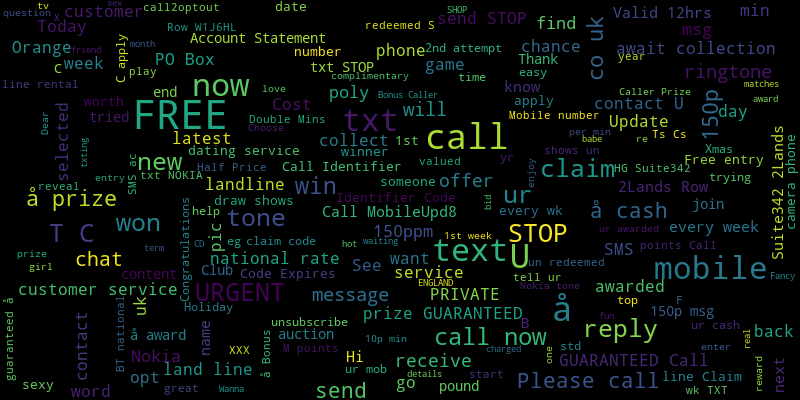

In [8]:
# BEGIN SOLUTION
spam_messages = " ".join(train_df[train_df["target"] == "spam"]["sms"].tolist())
ham_messages = " ".join(train_df[train_df["target"] == "ham"]["sms"].tolist())

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(spam_messages).to_image()
# END SOLUTION

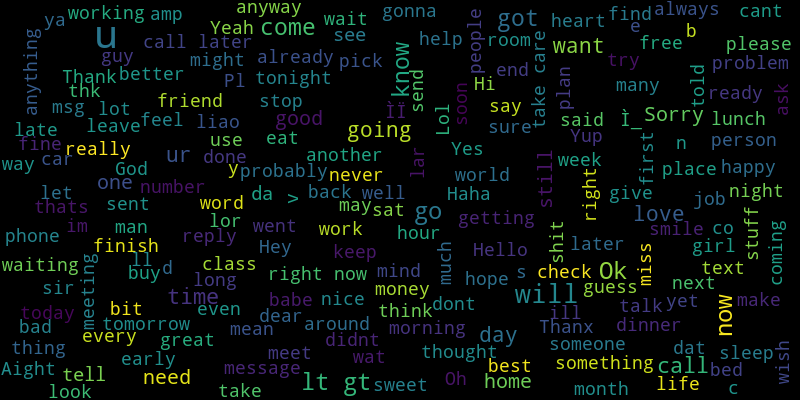

In [9]:
# BEGIN SOLUTION
wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(ham_messages).to_image()
# END SOLUTION

As expected, the words such as _call, free, urgent, text, claim, prize_ are dominant in spam messages compared to non-spam messages.    

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Bag-of-words encoding and model building
<hr>

Now it's time to build our models. Let's start by creating `X_train`, `y_train`, `X_test`, and `y_test` from the `train_df` and `test_df` defined above.

Note that `X_train` here is a 1-D array (or `Series`) rather than a 2-D array or `DataFrame`. This is because, unlike most other transformers, `CountVectorizer` expects a one-dimensional sequence of text documents as input.

In [10]:
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]

In [11]:
X_train.shape

(4457,)

Now let's train the dummy classifier. 

In [12]:
dummy = DummyClassifier()
dummy_scores = cross_val_score(dummy, X_train, y_train)
dummy_scores

array([0.86210762, 0.86210762, 0.8630752 , 0.86195286, 0.86195286])

In [13]:
dummy_scores.mean()

np.float64(0.862239233390205)

In [14]:
train_df["target"].value_counts()

target
ham     3843
spam     614
Name: count, dtype: int64

The dummy model achieves an accuracy of 0.86, which might seem quite high at first. However, this is largely due to class imbalance in our dataset. There are many more ham messages (3,843) than spam messages (614). As a result, a model that simply predicts every message as ham would already achieve high accuracy, even though it performs poorly at identifying spam.

<br><br>

For this lab we will be encoding the `sms` column with bag-of-words representation. Let's explore this representation. 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(X_train)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [16]:
vocab = cv.get_feature_names_out()
vocab.shape

(7682,)

Our dataset is rather small and the vocabulary size is < 8K. Now let's explore some words in the vocabulary. 

In [17]:
vocab[:10]  # First 10 words

array(['00', '000', '000pes', '008704050406', '0089', '0121',
       '01223585236', '01223585334', '0125698789', '02'], dtype=object)

In [18]:
vocab[0::100]  # Every 100th word

array(['00', '08712101358', '09061701851', '12mths', '2find', '440',
       '69911', '86888', 'accommodationvouchers', 'aint', 'answerin',
       'asa', 'b4190604', 'become', 'bleak', 'brainy', 'buzz', 'causing',
       'chinese', 'colleagues', 'converter', 'cttargg', 'deduct',
       'different', 'donyt', 'eastenders', 'entitled', 'expected',
       'feellikw', 'flowing', 'frnt', 'george', 'gower', 'hand', 'here',
       'hotmix', 'ill', 'interesting', 'jaykwon', 'kath', 'lamp', 'lido',
       'loosing', 'madoke', 'mcr', 'miserable', 'movie', 'nattil',
       'nooooooo', 'okies', 'overa', 'payments', 'placed', 'postal',
       'problem', 'quoting', 'recovery', 'restocked', 'runs',
       'scrumptious', 'shaking', 'signing', 'sms', 'sparkling',
       'statements', 'submitted', 'sweater', 'telly', 'those', 'tonite',
       'tuesday', 'unrecognized', 'very', 'wallpaper', 'wewa', 'women',
       'yay'], dtype=object)

In [19]:
vocab[7600:]  # Last 82 words

array(['yay', 'yeah', 'year', 'years', 'yeh', 'yelling', 'yellow',
       'yelow', 'yen', 'yeovil', 'yep', 'yer', 'yes', 'yest', 'yesterday',
       'yet', 'yetty', 'yetunde', 'yi', 'yijue', 'ym', 'ymca', 'yo',
       'yoga', 'yogasana', 'yor', 'you', 'youdoing', 'youi', 'young',
       'younger', 'youphone', 'your', 'youre', 'yourjob', 'yours',
       'yourself', 'youuuuu', 'youwanna', 'youåõre', 'yoville', 'yowifes',
       'yoyyooo', 'yr', 'yrs', 'ystrday', 'ything', 'yummmm', 'yummy',
       'yun', 'yunny', 'yuo', 'yuou', 'yup', 'yupz', 'zac', 'zaher',
       'zealand', 'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zogtorius',
       'zoom', 'zyada', 'åè10', 'åð', 'åòharry', 'åòit', 'åômorrow',
       'åôrents', 'ì_', 'ì¼1', 'ìï', 'û_', 'û_thanks', 'ûªm', 'ûªt',
       'ûªve', 'ûò', 'ûówell'], dtype=object)

These words are going to be features in our model. 

<br><br><br><br>

<div class="alert alert-info">
    
### 2.1 `SVC` with default hyperparameters
rubric={autograde}

Above we created a `CountVectorizer` but if we want to carry out cross-validation without breaking the golden rule, we'll need to create a pipeline. 

**Your tasks:**

1. Build a pipeline with two steps
    - Step 1: `CountVectorizer` with `stop_words='english'`
    - Step 2: `SVC` with `random_state=123` and default hyperparameters.

2. Show cross-validation scores in different folds and report the mean cross-validation score.

</div>

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [20]:
svc_pipe = None
mean_cv_svc = None

# BEGIN SOLUTION
svc_pipe = make_pipeline(CountVectorizer(stop_words="english"), SVC(random_state=123))
cv_svc_scores = cross_val_score(svc_pipe, X_train, y_train)
mean_cv_svc = cv_svc_scores.mean()
cv_svc_scores
# END SOLUTION

array([0.97757848, 0.98542601, 0.96857464, 0.97867565, 0.97530864])

In [21]:
pd.DataFrame(cross_validate(svc_pipe, X_train, y_train))

,fit_time,score_time,test_score
0,0.354911,0.076690,0.977578
1,0.355542,0.079212,0.985426
2,0.361100,0.074531,0.968575
3,0.351679,0.075382,0.978676
4,0.352319,0.077729,0.975309


In [22]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

<div class="alert alert-info">
    
### 2.2 Running a cross-validation fold without sklearn tools 
rubric={autograde}

Scikit-learn provides many convenient utilities such as `make_pipeline` and `cross_validate`, which simplify model training and evaluation. However, these high-level tools can sometimes make it harder to understand what's happening behind the scenes.

**Your tasks:**

1. Manually compute the validation score for an SVC model on the first fold. That is, train on 80% and validate on the remaining 20% of the `X_train` data.
    - Use the provided `CountVectorizer` and `SVC` objects along with `X_train` and `y_train`, splitting them further with `train_test_split(..., shuffle=False)`. 
    - Do not use Scikit-learn’s `Pipeline`, `cross_validate`, or `cross_val_score`.
    - Save the resulting score in a variable called `fold_score`.
    
> 💡 Note: You might notice slight differences between the score you obtained here and the first fold score from Section 2.1. This is because `cross_val_score` uses stratified sampling, ensuring that each training and validation split has roughly the same proportion of spam  and ham messages. In contrast, our manual split here may not preserve the original class balance as effectively.

</div>

In [23]:
# Fit the pipeline so we can access its individual steps
svc_pipe.fit(X_train, y_train)

# Extract the fitted CountVectorizer and SVC objects from the pipeline which you should be using in this exercise.
countvec_q_2_2 = svc_pipe["countvectorizer"]
svc_q_2_2 = svc_pipe["svc"]

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 5

In [24]:
fold_score = None

# BEGIN SOLUTION

X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

X_train_fold_vec = countvec_q_2_2.fit_transform(X_train_fold)
X_valid_fold_vec = countvec_q_2_2.transform(X_valid_fold)

svc_q_2_2.fit(X_train_fold_vec, y_train_fold)
fold_score = svc_q_2_2.score(X_valid_fold_vec, y_valid_fold)

# END SOLUTION

In [25]:
fold_score

0.9753363228699552

In [26]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<br><br>

## Exercise 3: Hyperparameter optimization
<hr>

Let's carry out hyperparameter optimization for SVC. For all the sub-parts of this question, we will be using our `svc_pipe` from the previous exercise.

So far we have been writing loops to try a bunch of different hyperparameter values and pick the one with lowest cross-validation error. This operation is so common that `scikit-learn` has some [built-in classes](https://scikit-learn.org/stable/modules/grid_search.html) to do it for you. In this exercise, we will explore two such classes:

1. [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
2. [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### Example: Optimizing `C` for SVM RBF using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

The code below carries out: 

* Hyperparameter search over `C` by sweeping the hyperparameter through the values $10^{-2}, 10^{-1}, 1, 10^{1}, 10^{2}$ using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and 5-fold cross-validation
* Plots training and cross-validation curves (mean train and mean cross-validation scores for different values of `C` from the `param_grid`) with `C` on the x-axis (use log scale) and scores on the y-axis.
* Identifies the "optimal" hyperparameter value and its associated best cross-validation score from the search using the `best_params_` attribute of the `GridSearchCV` object.
  
A few tips about `GridSearchCV`: 

- The starter code below defines the parameter grid for `C` which you can pass to your `GridSearchCV`. Note the syntax `svc__C`. We have two steps in our pipeline and we can access the parameters of these steps using `__` to go deeper. So `svc__C` means `C` of `svc` step of the pipeline. 
- Setting `n_jobs=-1` should speed things up (if you have a multi-core processor).
- Similar to `cross_validate`, you can pass `return_train_score=True` to your `GridSearchCV` object.
- By default, after carrying out the search, `GridSearchCV` also refits a model with the entire training set with the best hyperparameter values.


In [27]:
param_grid = {"svc__C": 10.0 ** np.arange(-2, 3)}

In [28]:
def plot_train_cv(param_vals, train_scores, cv_scores, xlabel, ylabel="accuracy"):
    plt.semilogx(param_vals, train_scores, label="train")
    plt.semilogx(param_vals, cv_scores, label="valid")
    plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [29]:
print(
    "We are carrying out %d 5-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

C_search = GridSearchCV(svc_pipe, param_grid, n_jobs=-1, cv=5, return_train_score=True)
C_search.fit(X_train, y_train)

We are carrying out 5 5-fold cross-validation experiments


,estimator,Pipeline(step..._state=123))])
,param_grid,"{'svc__C': array([1.e-02...e+01, 1.e+02])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,input,'content'


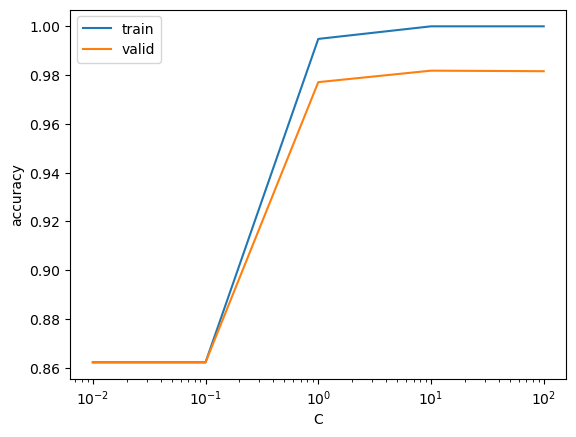

In [30]:
train_scores = C_search.cv_results_["mean_train_score"]
cv_scores = C_search.cv_results_["mean_test_score"]
plot_train_cv(param_grid["svc__C"], train_scores, cv_scores, xlabel="C")

In [31]:
# identify best C
best_C = C_search.best_params_["svc__C"]
best_C_score = C_search.best_score_
print("Best hyperparameter values: %0.3f" % (best_C))
print("Best score: %0.3f" % (best_C_score))

Best hyperparameter values: 10.000
Best score: 0.982


We can see that as `C` increases, the training score improves. It's also important to note that the gap between training and validation scores doesn't change much once `C` reaches 1.

While we do see some improvement after tuning `C` to 10, the difference isn't substantial. So in this case, it might be better to stick with the simpler model using `C=1`, since it performs nearly as well without the added complexity.

<br><br>

<div class="alert alert-info">
    
### 3.1 `GridSearchCV`: Jointly optimizing `C`, `gamma`
rubric={autograde}

So far, we have optimized only one hyperparameter at a time. Now, let's jointly optimize the `C`, along with `gamma` using `GridSearchCV`. 

**Your tasks:**

1. Expand your grid search to cover the `gamma` hyperparameter in addition to `C`, sweeping the hyperparameter through values $10^{-2}, 10^{-1}, \ldots, 10^{2}$ for both `C` and `gamma`.
2. Store the following in the corresponding variables below:
   - `param_grid`: your parameter grid
   - `gamma_C_search`: the fitted grid search object
   - `best_gamma_C`: a dictionary containing the best hyperparameters found by your grid search
   - `best_gamma_C_score`: the mean cross-validation score corresponding to the best parameters

</div>

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 5

In [32]:
param_grid = None  # Parameter grid for grid search
gamma_C_search = None  # Grid search object
best_gamma_C = None  # Best hyperparameter values (dictionary)
best_gamma_C_score = None  # Mean CV score with best hyperparameters

# BEGIN SOLUTION
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-2, 3),
    "svc__C": 10.0 ** np.arange(-2, 3),
}
print(
    "We are carrying out %d 5-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

gamma_C_search = GridSearchCV(svc_pipe, param_grid, n_jobs=-1, return_train_score=True)
gamma_C_search.fit(X_train, y_train)

best_gamma_C = gamma_C_search.best_params_
best_gamma_C_score = gamma_C_search.best_score_
# END SOLUTION

print("Best hyperparameter values: ", best_gamma_C)
print("Best score: %0.3f" % best_gamma_C_score)

We are carrying out 25 5-fold cross-validation experiments
Best hyperparameter values:  {'svc__C': np.float64(10.0), 'svc__gamma': np.float64(0.1)}
Best score: 0.982


In [33]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.2 `RandomizedSearchCV`: Jointly optimizing SVM RBF and `CountVectorizer` hyperparameters 
rubric={accuracy,quality}

Just like estimators, transformers also have hyperparameters. In this exercise, you'll jointly optimize hyperparameters of `SVC` as well as `CountVectorizer` using `RandomizedSearchCV`. 

Unlike `GridSearchCV`, which exhaustively tests all combinations, `RandomizedSearchCV` samples a fixed number of random hyperparameter combinations from the specified distributions or grids.

**Your tasks:**

1. Use [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) with `n_iter` of your choice to jointly optimize the following hyperparameters:
    - `C` and `gamma` for the SVC (RBF kernel)
    - `binary` and `max_features` for the `CountVectorizer`
2. Choose reasonable ranges or probability distributions for the hyperparameters based on your judgment You may use either a parameter grid or continuous distributions.
4. Display both:
    - The best hyperparameter values found by the random search
    - The best cross-validation score obtained by the random search

</div>

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

In [34]:
param_dist = None

# BEGIN SOLUTION
from scipy.stats import expon, lognorm, loguniform, norm, randint, uniform

param_dist = {
    "svc__C": loguniform(1e-2, 1e3),
    "svc__gamma": loguniform(1e-3, 1e3),
    "countvectorizer__max_features": randint(10, 8000),
    "countvectorizer__binary": [True, False],
}
# END SOLUTION

In [35]:
random_search = None

# BEGIN SOLUTION
random_search = RandomizedSearchCV(
    svc_pipe,
    param_dist,
    n_iter=100,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)
# END SOLUTION

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step..._state=123))])
,param_distributions,"{'countvectorizer__binary': [True, False], 'countvectorizer__max_features': <scipy.stats....t 0x12b608830>, 'svc__C': <scipy.stats....t 0x12b608440>, 'svc__gamma': <scipy.stats....t 0x12b5c3750>}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [36]:
random_search_best_params = None
random_search_best_score = None
# BEGIN SOLUTION
random_search_best_params = random_search.best_params_
random_search_best_score = random_search.best_score_
print("Best hyperparameter values: ", random_search_best_params)
print("Best score: %0.3f" % random_search_best_score)
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_svc__C",
        "param_countvectorizer__max_features",
        "param_countvectorizer__binary",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T
# END SOLUTION

Best hyperparameter values:  {'countvectorizer__binary': False, 'countvectorizer__max_features': 2500, 'svc__C': np.float64(298.4636456236878), 'svc__gamma': np.float64(0.001816926471964085)}
Best score: 0.983


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,80,80,80,80,80,80,80,80,80,80
mean_train_score,0.998486,0.999495,0.998429,0.993269,0.999551,0.993045,0.995905,0.999776,0.999439,0.999439,...,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239
mean_test_score,0.983395,0.982273,0.9816,0.981375,0.981151,0.981151,0.980703,0.980702,0.98003,0.980029,...,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239
param_svc__C,298.463646,30.036384,368.261466,51.20481,828.236612,1.34633,162.821664,653.164135,157.114671,98.680572,...,0.010488,0.019879,0.086004,0.030036,0.010659,0.370122,0.069276,0.152405,0.021571,0.053788
param_countvectorizer__max_features,2500,3397,2169,2694,4179,3872,1256,6124,3092,3044,...,4194,2904,474,902,7437,1071,1245,6246,2019,3283
param_countvectorizer__binary,False,False,False,False,False,True,True,True,True,False,...,True,False,False,False,False,True,True,True,False,False
mean_fit_time,0.242,0.616057,0.22284,0.275699,0.508911,0.451698,0.194561,0.855026,0.304052,0.263478,...,1.418836,0.614018,0.45488,0.347646,0.914267,0.343466,0.855014,1.040005,0.878587,0.958615


In [37]:
random_search_best_params

{'countvectorizer__binary': False,
 'countvectorizer__max_features': 2500,
 'svc__C': np.float64(298.4636456236878),
 'svc__gamma': np.float64(0.001816926471964085)}

In [38]:
random_search_best_score

np.float64(0.9833952378795427)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.3  `RandomizedSearchCV` and `GridSearchCV`
rubric={reasoning}

**Your tasks:**

1. Did the best `C` and `gamma` value you found in `RandomizedSearchCV` match what you got in section 3.1 using `GridSearchCV`? In a broader context, should these values necessarily align? Explain your reasoning.

</div>

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 3

_Type your answer here, replacing this text._

No, the best `C` and `gamma` values are not the same in `RandomizedSearchCV` compared to section 3.1. Especially for `C`, the best `C` was 10 in section 3.1 using `GridSearchCV`, but a different number in `RandomizedSearchCV`. 

In a broader context, these values don't necessarily need to align. `RandomizedSearchCV` samples randomly from a distribution of reasonable values for a fixed number of iterations. Because of its random nature, it explores more parts of the search space. In comparison, `GridSearchCV` exhaustively evaluates a predefined grid of values, which limits the hyperparameter search space and values it can explore. 

Moreover, we're now performing a joint search over a 4-dimensional parameter space (optimizing hyperparameters for both `SVC` and `CountVectorizer`), but in section 3.1 we only searched over a 2-dimensional space (just `C` and `gamma` for `SVC`). Optimizing more hyperparameters simultaneously can lead to different optimum, because the best values for `C` and `gamma` may depend on the settings of `binary` and `max_features`.

On a side note, we are trying more models now, so optimization bias can increase.

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Test results <a name="5"></a>
<hr>

Now that we have done extensive hyperparameter search, it's time to try our best model on the test split. 

<div class="alert alert-info">
    
### 4.1 Report test scores
rubric={autograde}

**Your tasks:**
1. Evaluate your top-performing model on both the training and test sets, then assign the results to the respective variables provided below.

</div>

<div class="alert alert-warning">

Solution_4.1
    
</div>

_Points:_ 2

In [39]:
best_cv_score = None
train_score = None
test_score = None

# BEGIN SOLUTION
best_cv_score = random_search.best_score_
train_score = random_search.score(X_train, y_train)
test_score = random_search.score(X_test, y_test)
# END SOLUTION

print("CV score: %0.3f" % best_cv_score)
print("Train score: %0.3f" % train_score)
print("Test score: %0.3f" % test_score)

CV score: 0.983
Train score: 0.998
Test score: 0.981


<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 4.2 Discussion and evaluation
rubric={reasoning}

**Your tasks:**

1. How does your test accuracy compare to your validation accuracy? Briefly comment. 
2. Try out your best model on a couple of fake spam and ham (non-spam) text messages. You can start with some sample messages given below.  
3. Do you believe that this model is likely to identify spam messages in the wild with the observed accuracy? Briefly discuss.

</div>

<div class="alert alert-warning">

Solution_4.2
    
</div>

_Points:_ 4

In [40]:
sample_text_msgs = [
    """Call 8375467843 immediately. URGENT!! 
                    You have a free gift waiting for you...""",  # potential spam
    "MDS is fun.",  # potential non-spam
    """This is very URGENT!! This week the MDS team has decided that 
                      all of you get 100% on all assignments and quizzes for free. 
                      Visit https://bit.ly/2T15k6V to check your grades.""",  # potential spam
]

_Type your answer here, replacing this text._

In [41]:
# BEGIN SOLUTION
random_search.predict(sample_text_msgs)
# END SOLUTION

array(['spam', 'ham', 'spam'], dtype=object)

The test scores are consistent with the validation scores. So our cross-validation results seem representative of the test data and the model doesn't seem to overfit. That said, I don't believe that we have a close to perfect and a reliable system for spam identification. Our dataset is rather small and the `most_frequent` baseline for the dataset is pretty high. More rigorous evaluation, probably on some data in the wild, would give us a better picture. 

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 5: Food for thought
<hr>

Each lab will have a few challenging questions. In some labs, I will be including challenging questions which lead to the material in the upcoming week. These are usually low-risk questions and will contribute to maximum 5% of the lab grade. The main purpose here is to challenge yourself or dig deeper in a particular area. When you start working on labs, attempt all other questions before moving to these questions. **If you are running out of time, please skip these questions.** 

We will be more strict with the marking of these questions. There might not be model answers. If you want to get full points in these questions, your answers need to
- be thorough, thoughtful, and well-written
- provide convincing justification and appropriate evidence for the claims you make 
- impress the reader of your lab with your understanding of the material, your analytical and critical reasoning skills, and your ability to think on your own

![](img/eva-game-on.png)

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### (Challenging) 5.1
rubric={reasoning}

In the EDA we noticed that the average length of spam vs. non-spam messages is quite different yet we are not using this feature in our current model. In this exercise, you will incorporate this feature in the model. 

**Your tasks:**
1. Add a new numeric feature called `sms_length` in the modeling which represents the length of text in characters, along with the bag of words features. 
2. What's the cross-validation accuracy of SVC with default hyperparameters and only `sms_length` feature? 
3. What's the cross-validation accuracy of SVC with default hyperparameters and `sms_length` and `CountVectorizer` features together? 
4. Discuss your observations.

</div>

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

_Points:_ 1

_Type your answer here, replacing this text._

Let's add the numeric feature `sms_length`. 

In [42]:
# BEGIN SOLUTION
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

train_df["sms_length"] = train_df["sms"].str.len()
# END SOLUTION

Let's examine the results with only length feature. 

In [43]:
# BEGIN SOLUTION
pipe_len_only = make_pipeline(StandardScaler(), SVC())
cross_val_score(pipe_len_only, train_df[["sms_length"]], y_train)
# END SOLUTION

array([0.8632287 , 0.88901345, 0.87093154, 0.88776655, 0.87429854])

We are getting an accuracy a bit better than the dummy classifier simply using the length feature. 

Let's find out what happens when we use both bag-of-words and length features together. 

In [44]:
# BEGIN SOLUTION
numeric_features = ["sms_length"]
text_feature = "sms"
preprocessor_both = make_column_transformer(
    (StandardScaler(), numeric_features),
    (
        make_pipeline(CountVectorizer(stop_words="english"), MaxAbsScaler()),
        text_feature,
    ),
)

pipe_len_countvec = make_pipeline(preprocessor_both, SVC())
cross_val_score(pipe_len_countvec, train_df[["sms_length", "sms"]], y_train)
# END SOLUTION

array([0.96973094, 0.97982063, 0.95959596, 0.97530864, 0.96857464])

The accuracy is comparable to what we got with just the bag-of-words features, shown below. 

In [45]:
# BEGIN SOLUTION
text_feature = "sms"
preprocessor_cv_only = make_column_transformer(
    (make_pipeline(CountVectorizer(stop_words="english"), MaxAbsScaler()), text_feature)
)

pipe_countvec_only = make_pipeline(preprocessor_cv_only, SVC())
cross_val_score(pipe_countvec_only, train_df[["sms"]], y_train)
# END SOLUTION

array([0.97197309, 0.97421525, 0.95510662, 0.9708193 , 0.96969697])

**Observations**: Adding this new feature "sms_length" does not seem to improve the overall results. That said, it's interesting that we can get an accuracy of ~87% on this task by simply looking at which message is longer in length. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### (Challenging) 5.2
rubric={reasoning}

**Your tasks:**

There are many software packages that automate hyperparameter tuning beyond `GridSearchCV` and `RandomizedSearchCV`. Here are some examples:

**Tied to scikit-learn**
- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [TPOT](https://github.com/rhiever/tpot) (genetic programming approach)

**General-purpose optimizers**
- [Optuna](https://optuna.org/)
- [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)
- [FLAML](https://microsoft.github.io/FLAML/)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)

*(Note: Some older packages like MOE, hyperband, pybo, Spearmint, and BayesOpt are no longer actively maintained but are interesting historically.)*

**Your tasks:**

1. Pick one of the tools above and try it on the task from the previous question.  
2. Briefly describe:
   - What algorithm it uses for optimization  
   - How it compares to `RandomizedSearchCV` in terms of ease of use and performance  
3. Reflect on whether you would use it in practice and why.

> 💡 Tip: If runtime or installation is an issue, feel free to analyze the package's example notebooks instead of running a full experiment.

</div>

<div class="alert alert-warning">
    
Solution_5.2
    
</div>

_Points:_ 1

<!-- END QUESTION -->

<br><br><br><br>

Before submitting your assignment, please ensure you have followed all the steps in the **Instructions** section at the top.  

### Submission checklist  

- [ ] Restart the kernel and run all cells (▶▶ button)
- [ ] Make at least three commits to your Github repository. 
- [ ] The `.ipynb` file runs without errors and shows all outputs.  
- [ ] Only the `.ipynb` file and required output files are uploaded (no extra files).  
- [ ] If the `.ipynb` file is too large to render on Gradescope, upload a Web PDF and/or HTML version as well.
- [ ] Include the link to your lab GitHub repository below the instructions.  


Congratulations on finishing the homework. You made it through a challenging week! Well done 👏👏! 

![](img/eva-well-done.png)

